# Attention Analysis

This notebook contains visualizations of the attention patterns in four transformer-based language models (i.e., BERT, GPT-2, XLNet and ELECTRA). The dataset consists of 1000 samples from the bookcorpus, which is preprocessed in another notebook (i.e., attention, pos tags, tokens and value norms are added for each sample).

TODO:
- look at entropy of uniform attention for GPT-2


In [1]:
!pip -q install datasets

from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 163kB 8.7MB/s 
     |████████████████████████████████| 17.7MB 252kB/s 
     |████████████████████████████████| 245kB 59.9MB/s 
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data classes with plot methods

In [2]:
import numpy as np
import seaborn as sns

from typing import Tuple, Dict, Optional
from matplotlib import pyplot as plt
from datasets import load_from_disk


class Data(object):
    def __init__(self, data, special_tokens: Optional[Dict[str, str]] = None, model_dim: Tuple[int, int] = (12, 12),
                 model_type: str = "bidirectional"):
        self.model_dim: Tuple[int, int] = model_dim
        self.n_layers, self.n_heads = self.model_dim
        self.model_type: str = model_type
        assert model_type in ["bidirectional", "causal"]
        self.special_tokens: Dict[str, str] = special_tokens if special_tokens is not None else dict()
        self.data = data
        self.n_docs = len(self.data)
        self.avg_attns: dict = self.calculate(calc_type="attention")
        self.avg_attn_norm_prods = self.calculate(calc_type="attention * ||f(x)||")
        self.entropies: dict = self.calculate_entropies()
        self.color: dict = {
            "BLACK": "k",
            "GREEN": "#59d98e",
            "SEA": "#159d82",
            "BLUE": "#3498db",
            "PURPLE": "#9b59b6",
            "GREY": "#95a5a6",
            "RED": "#e74c3c",
            "ORANGE": "#f39c12",
        }

    def data_iterator(self):
        for i, doc in enumerate(self.data):
            if i % 100 == 0 or i == len(self.data) - 1:
                print("{:.1f}% done".format(100.0 * (i + 1) / len(self.data)))
            yield np.array(doc["tokens"]), np.array(doc["attention"]), np.array(doc["pos"]), np.array(doc["value_norms"])

    def calculate(self, calc_type: str) -> Dict[str, np.ndarray]:
        assert calc_type in ["attention", "||f(x)||", "attention * ||f(x)||"], "type should be 'attention', '||f(x)||' or 'attention * ||f(x)||'"
        storage = {
            k: np.zeros(self.model_dim) for k in [
                "self", "left", "punct",  # special positions
                "noun", "verb", "det", "propn", "adp", "num", "punct2"  # simple POS tags
            ]
        }
        pos_doc_count = {
            "noun": 0,
            "verb": 0,
            "det": 0,
            "propn": 0,
            "adp": 0,
            "num": 0,
            "punct2": 0,
        }
        reverse_pos_map = {
            "NOUN": "noun",
            "VERB": "verb",
            "DET": "det",
            "PROPN": "propn",
            "ADP": "adp",
            "NUM": "num",
            "PUNCT": "punct2",
        }
        if self.model_type == "bidirectional":
            storage["right"] = np.zeros(self.model_dim)
        if self.special_tokens is not None:
            for k in self.special_tokens.keys():
                storage[k], \
                storage[k + "_" + k], \
                storage["rest_" + k], \
                storage[k + "_rest"], \
                storage["rest_rest_" + k] = (np.zeros(self.model_dim) for _ in range(5))

        print("Computing {} stats".format(calc_type))
        for tokens, attns, pos, norms in self.data_iterator():
            n_tokens = attns.shape[-1]

            # create masks indicating where particular tokens are
            puncts, \
            noun, verb, det, propn, adp, num, punct2 = (np.zeros(n_tokens) for _ in range(8))
            sp_tkns_pos = {tkn: np.zeros(n_tokens) for tkn in self.special_tokens.values()}
            for position, (token, pos_tag) in enumerate(zip(tokens, pos)):
                if token == "." or token == ",":
                    puncts[position] = 1
                if token in sp_tkns_pos.keys():
                    sp_tkns_pos[token][position] = 1
                if pos_tag == "NOUN":
                    noun[position] = 1
                    pos_doc_count[reverse_pos_map[pos_tag]] += 1
                if pos_tag == "VERB":
                    verb[position] = 1
                    pos_doc_count[reverse_pos_map[pos_tag]] += 1
                if pos_tag == "DET":
                    det[position] = 1
                    pos_doc_count[reverse_pos_map[pos_tag]] += 1
                if pos_tag == "PROPN":
                    propn[position] = 1
                    pos_doc_count[reverse_pos_map[pos_tag]] += 1
                if pos_tag == "ADP":
                    adp[position] = 1
                    pos_doc_count[reverse_pos_map[pos_tag]] += 1
                if pos_tag == "NUM":
                    num[position] = 1
                    pos_doc_count[reverse_pos_map[pos_tag]] += 1
                if pos_tag == "PUNCT":
                    punct2[position] = 1
                    pos_doc_count[reverse_pos_map[pos_tag]] += 1

            # rename the keys back to the given names, e.g., [SEP] back to sep.
            for k, v in self.special_tokens.items():
                sp_tkns_pos[k] = sp_tkns_pos.pop(v)

            sp_tkn_masks = {}
            for k, v in sp_tkns_pos.items():
                # create masks indicating which positions are relevant for each key
                t_t = np.ones((n_tokens, n_tokens))
                t_t *= v[np.newaxis]
                t_t *= v[:, np.newaxis]

                rest_t = np.ones((n_tokens, n_tokens))
                rest_t *= (np.ones(n_tokens) - v)[:, np.newaxis]
                rest_t *= v[np.newaxis]

                t_rest = np.ones((n_tokens, n_tokens))
                t_rest *= v[:, np.newaxis]
                t_rest *= (np.ones(n_tokens) - v)[np.newaxis]

                rest_rest_t = np.ones((n_tokens, n_tokens))
                rest_rest_t *= (np.ones(n_tokens) - v)[:, np.newaxis]
                rest_rest_t *= (np.ones(n_tokens) - v)[np.newaxis]

                sp_tkn_masks[k] = np.tile(v[np.newaxis], [n_tokens, 1])
                sp_tkn_masks[k + "_" + k] = t_t
                sp_tkn_masks["rest_" + k] = rest_t
                sp_tkn_masks[k + "_rest"] = t_rest
                sp_tkn_masks["rest_rest_" + k] = rest_rest_t

            # store the masks
            selectors = {
                "self": np.eye(n_tokens, n_tokens),
                "left": np.eye(n_tokens, n_tokens, -1),
                "punct": np.tile(puncts[np.newaxis], [n_tokens, 1]),
                "noun": np.tile(noun[np.newaxis], [n_tokens, 1]),
                "verb": np.tile(verb[np.newaxis], [n_tokens, 1]),
                "det": np.tile(det[np.newaxis], [n_tokens, 1]),
                "propn": np.tile(propn[np.newaxis], [n_tokens, 1]),
                "adp": np.tile(adp[np.newaxis], [n_tokens, 1]),
                "num": np.tile(num[np.newaxis], [n_tokens, 1]),
                "punct2": np.tile(punct2[np.newaxis], [n_tokens, 1])
            }
            # add the attention to one position to the right
            if self.model_type == "bidirectional":
                selectors["right"] = np.eye(n_tokens, n_tokens, 1)
            # add the special tokens masks
            for k, v in sp_tkn_masks.items():
                selectors[k] = v

            # get the average attention for each token type
            # TODO: I now assume each special token only occurs once. (Make it flexible.)
            for key, selector in selectors.items():
                if key in np.array([[k + "_" + k, k + "_rest"] for k in self.special_tokens.keys()]).flatten():
                    denom = 1
                elif key in np.array([["rest_rest_" + k, "rest_" + k] for k in self.special_tokens.keys()]).flatten():
                    denom = n_tokens - 1
                else:
                    denom = n_tokens

                # pos tags may not occur in every sentence
                val_docs = pos_doc_count[key] if key in pos_doc_count.keys() else self.n_docs
                    
                if calc_type == "attention":
                    storage[key] += (
                            (attns * selector[np.newaxis, np.newaxis]).sum(-1).sum(-1) /
                            (val_docs * denom))
                elif calc_type == "attention * ||f(x)||":
                    storage[key] += (
                            (attns * norms[:, :, np.newaxis, :] * selector[np.newaxis, np.newaxis]).sum(-1).sum(-1) /
                            (val_docs * denom))
        return storage

    def calculate_entropies(self):
        uniform_attn_entropy = 0  # entropy of uniform attention
        sp_tkn_entropies = {k: np.zeros(self.model_dim) for k in self.special_tokens.keys()}
        entropies = np.zeros(self.model_dim)  # entropy of attention heads
        entropies_noun, entropies_verb, entropies_det, entropies_propn, \
        entropies_adp, entropies_num, entropies_punct2 = (np.zeros(self.model_dim) for _ in
                                                          range(7))  # entropy of attention from simple POS tags
        n_noun_docs, n_verb_docs, n_det_docs, n_propn_docs, n_adp_docs, \
        n_num_docs, n_punct2_docs = (0 for _ in range(7))  # counts the number of documents that have pos tag x in it.

        print("Computing entropy stats")
        for tokens, attns, pos, _ in self.data_iterator():
            attns = 0.9999 * attns + (0.0001 / attns.shape[-1])  # smooth to avoid NaNs
            if self.model_type == "bidirectional":
                uniform_attn_entropy -= np.log(1.0 / attns.shape[-1])
            elif self.model_type == "causal":
                uniform_attn_entropy -= np.mean([np.log(1.0 / (i + 1)) for i in range(attns.shape[-1])])
            entropies -= (attns * np.log(attns)).sum(-1).mean(-1)
            # do the same for the special tokens
            for k in sp_tkn_entropies.keys():
                t_pos = [i for i, x in enumerate(tokens) if x == self.special_tokens[k]]
                sp_tkn_entropies[k] -= (attns * np.log(attns))[:, :, t_pos].sum(-1).mean(-1)
            # do the same for the simple pos tags
            noun_positions, verb_positions, det_positions, propn_positions, \
            adp_positions, num_positions, punct2_positions = ([i for i, token in enumerate(pos) if token == pos_tag] \
                                                              for pos_tag in
                                                              ["NOUN", "VERB", "DET", "PROPN", "ADP", "NUM", "PUNCT"])

            if noun_positions != list():
                n_noun_docs += 1
                entropies_noun -= (attns * np.log(attns))[:, :, noun_positions].sum(-1).mean(-1)
            if verb_positions != list():
                n_verb_docs += 1
                entropies_verb -= (attns * np.log(attns))[:, :, verb_positions].sum(-1).mean(-1)
            if det_positions != list():
                n_det_docs += 1
                entropies_det -= (attns * np.log(attns))[:, :, det_positions].sum(-1).mean(-1)
            if propn_positions != list():
                n_propn_docs += 1
                entropies_propn -= (attns * np.log(attns))[:, :, propn_positions].sum(-1).mean(-1)
            if adp_positions != list():
                n_adp_docs += 1
                entropies_adp -= (attns * np.log(attns))[:, :, adp_positions].sum(-1).mean(-1)
            if num_positions != list():
                n_num_docs += 1
                entropies_num -= (attns * np.log(attns))[:, :, num_positions].sum(-1).mean(-1)
            if punct2_positions != list():
                n_punct2_docs += 1
                entropies_punct2 -= (attns * np.log(attns))[:, :, punct2_positions].sum(-1).mean(-1)

        uniform_attn_entropy /= self.n_docs
        entropies /= self.n_docs
        for k in sp_tkn_entropies.keys():
            sp_tkn_entropies[k] /= self.n_docs
        entropies_noun /= n_noun_docs
        entropies_verb /= n_verb_docs
        entropies_det /= n_det_docs
        entropies_propn /= n_propn_docs
        entropies_adp /= n_adp_docs
        entropies_num /= n_num_docs
        entropies_punct2 /= n_punct2_docs

        return_entropies = {
            "uniform": uniform_attn_entropy,
            "entropies": entropies,
            "noun": entropies_noun,
            "verb": entropies_verb,
            "det": entropies_det,
            "propn": entropies_propn,
            "adp": entropies_adp,
            "num": entropies_num,
            "punct2": entropies_punct2,
        }

        # add the special tokens entropies
        for k, v in sp_tkn_entropies.items():
            return_entropies[k] = v

        return return_entropies

    def plot_attn(self, example: dict, heads: Tuple[int, int], n_tokens=5, from_end=True, width=3, example_sep=3,
                  word_height=1, pad=0.1):
        """Plots attention maps for the given example and attention heads."""

        for ei, (layer, head) in enumerate(heads):  # iterate over the requested attention heads
            yoffset = 1
            xoffset = ei * width * example_sep

            if from_end:  # display to last x words
                attn = np.array(example["attention"])[layer][head][-n_tokens:, -n_tokens:]
                attn = np.array(attn)
                attn /= attn.sum(axis=-1, keepdims=True)
                words = example["tokens"][-n_tokens:]
                words[0] = "..."
            else:  # display the first x words
                attn = np.array(example["attention"])[layer][head][:n_tokens, :n_tokens]
                attn = np.array(attn)
                attn /= attn.sum(axis=-1, keepdims=True)
                words = example["tokens"][:n_tokens]
                words[-1] = "..."

            # plot two columns of tokens
            for position, word in enumerate(words):
                plt.text(xoffset + 0, yoffset - position * word_height, word,
                         ha="right", va="center")
                plt.text(xoffset + width, yoffset - position * word_height, word,
                         ha="left", va="center")

            # plot the attention between the tokens in the columns
            n_words = len(words)
            start = 1 if from_end else 0
            end = n_words if from_end else n_words - 1
            for i in range(start, end):
                for j in range(start, end):
                    plt.plot([xoffset + pad, xoffset + width - pad],
                             [yoffset - word_height * i, yoffset - word_height * j],
                             color="blue", linewidth=1, alpha=attn[i, j])

    def get_data_points(self, head_data):
        xs, ys, avgs = [], [], []
        for layer in range(self.n_layers):
            for head in range(self.n_heads):
                ys.append(head_data[layer, head])
                xs.append(1 + layer)
            avgs.append(head_data[layer].mean())
        return xs, ys, avgs

    def add_line(self, key: str, ax, color: str, label: str, l_type: str = "attention", plot_avgs: bool = True,
                           y_lim: Optional[Tuple[int, int]] = None, pos: Optional[str] = None):
        assert l_type in ["attention", "attention * ||f(x)||"]
        xs, ys, avgs = self.get_data_points(self.avg_attns[key]) if l_type == "attention" else self.get_data_points(self.avg_attn_norm_prods[key])
        ax.scatter(xs, ys, s=12, label=label, color=self.color[color])
        if y_lim is not None: ax.set_ylim(y_lim[0], y_lim[1])
        if pos == "left":
            ax.set_ylabel("Attention") if l_type == "attention" else ax.set_ylabel("attention * ||f(x)||")
            ax.legend(loc="best")
            if plot_avgs:
                ax.plot(1 + np.arange(len(avgs)), avgs, color=self.color[color])
                ax.set_ylabel("Average attention") if l_type == "attention" else ax.set_ylabel("Average attention * ||f(x)||")
            ax.tick_params(axis="x", labelbottom=False)
        elif pos == "bottom":
            ax.set_xlabel("Layer")
            ax.legend(loc="best")
            if plot_avgs:
                ax.plot(1 + np.arange(len(avgs)), avgs, color=self.color[color])
            ax.tick_params(axis="y", labelleft=False)
        elif pos == "leftbottom":
            ax.set_xlabel("Layer")
            ax.set_ylabel("Attention") if l_type == "attention" else ax.set_ylabel("attention * ||f(x)||")
            ax.legend(loc="best")
            if plot_avgs:
                ax.plot(1 + np.arange(len(avgs)), avgs, color=self.color[color])
                ax.set_ylabel("Average attention") if l_type == "attention" else ax.set_ylabel("Average attention * ||f(x)||")
        else:
            ax.legend(loc="best")
            if plot_avgs:
                ax.plot(1 + np.arange(len(avgs)), avgs, color=self.color[color])
            ax.tick_params(axis="both", labelleft=False, labelbottom=False)

    def plot_entropies(self, ax, key: str, label: str, c: str, plot_unif: bool = False, pos: Optional[str] = None):
        uniform_attn_entropy = self.entropies["uniform"]
        xs, es, avg_es = self.get_data_points(self.entropies[key])
        ax.scatter(xs, es, c=self.color[c], s=5, label=label)
        ax.plot(1 + np.arange(self.n_layers), avg_es, c=self.color[c])
        if plot_unif:
            ax.plot([1, self.n_layers], [uniform_attn_entropy, uniform_attn_entropy], c="k", linestyle="--")
            ax.text(7, uniform_attn_entropy - 0.15, "uniform attention", ha="center")
        ax.legend(loc="best")
        if pos == "left":
            ax.set_ylabel("Average entropy")
            ax.tick_params(axis="x", labelbottom=False)
        elif pos == "bottom":
            ax.set_xlabel("Layer")
            ax.tick_params(axis="y", labelleft=False)
        elif pos == "leftbottom":
            ax.set_xlabel("Layer")
            ax.set_ylabel("Average entropy")
        else:
            ax.tick_params(axis="x", labelbottom=False)
            ax.tick_params(axis="y", labelleft=False)


class BertData(Data):
    def __init__(self, data):
        super().__init__(
            model_type="bidirectional",
            special_tokens={
                "sep": "[SEP]",
                "cls": "[CLS]"
            },
            data=data,
        )


class GPT2Data(Data):
    def __init__(self, data):
        super().__init__(
            model_type="causal",
            data=data,
        )


class XLNetData(Data):
    def __init__(self, data):
        super().__init__(
            model_type="bidirectional",
            special_tokens={
                "sep": "<sep>",
                "cls": "<cls>"
            },
            data=data,
        )


class ElectraData(Data):
    def __init__(self, data):
        super().__init__(
            model_type="bidirectional",
            special_tokens={
                "sep": "[SEP]",
                "cls": "[CLS]"
            },
            data=data,
        )


# Calculating the data

In [3]:
PATH = "./drive/My Drive/Attention/bookcorpus (1000 samples, train)/"

In [4]:
b_data = load_from_disk(PATH + "bert")
b_data = BertData(b_data)

Computing attention stats
0.1% done
10.1% done
20.1% done
30.1% done
40.1% done
50.1% done
60.1% done
70.1% done
80.1% done
90.1% done
100.0% done
Computing attention * ||f(x)|| stats
0.1% done
10.1% done
20.1% done
30.1% done
40.1% done
50.1% done
60.1% done
70.1% done
80.1% done
90.1% done
100.0% done
Computing entropy stats
0.1% done
10.1% done
20.1% done
30.1% done
40.1% done
50.1% done
60.1% done
70.1% done
80.1% done
90.1% done
100.0% done


In [5]:
g_data = load_from_disk(PATH + "gpt2")
g_data = GPT2Data(g_data)

Computing attention stats
0.1% done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:157: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:159: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


10.1% done
20.1% done
30.1% done
40.1% done
50.1% done
60.1% done
70.1% done
80.1% done
90.1% done
100.0% done
Computing attention * ||f(x)|| stats
0.1% done
10.1% done
20.1% done
30.1% done
40.1% done
50.1% done
60.1% done
70.1% done
80.1% done
90.1% done
100.0% done
Computing entropy stats
0.1% done
10.1% done
20.1% done
30.1% done
40.1% done
50.1% done
60.1% done
70.1% done
80.1% done
90.1% done
100.0% done


In [6]:
x_data = load_from_disk(PATH + "xlnet")
x_data = XLNetData(x_data)

Computing attention stats
0.1% done
10.1% done
20.1% done
30.1% done
40.1% done
50.1% done
60.1% done
70.1% done
80.1% done
90.1% done
100.0% done
Computing attention * ||f(x)|| stats
0.1% done
10.1% done
20.1% done
30.1% done
40.1% done
50.1% done
60.1% done
70.1% done
80.1% done
90.1% done
100.0% done
Computing entropy stats
0.1% done
10.1% done
20.1% done
30.1% done
40.1% done
50.1% done
60.1% done
70.1% done
80.1% done
90.1% done
100.0% done


In [7]:
e_data = load_from_disk(PATH + "electra")
e_data = ElectraData(e_data)

Computing attention stats
0.1% done
10.1% done
20.1% done
30.1% done
40.1% done
50.1% done
60.1% done
70.1% done
80.1% done
90.1% done
100.0% done
Computing attention * ||f(x)|| stats
0.1% done
10.1% done
20.1% done
30.1% done
40.1% done
50.1% done
60.1% done
70.1% done
80.1% done
90.1% done
100.0% done
Computing entropy stats
0.1% done
10.1% done
20.1% done
30.1% done
40.1% done
50.1% done
60.1% done
70.1% done
80.1% done
90.1% done
100.0% done


# Plotting

In [8]:
sns.set_style("darkgrid")

## Attention weights

### Attention

#### Special tokens

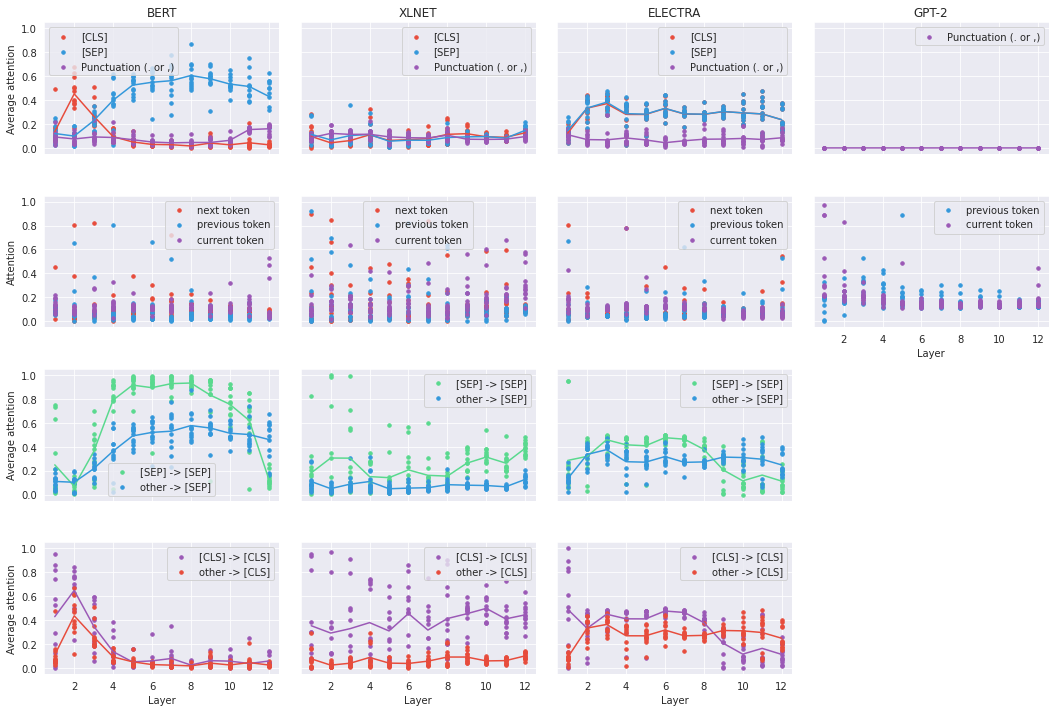

In [9]:
plt.figure(figsize=(15, 10))
y_lim = (-0.05, 1.05)

# BERT
ax = plt.subplot(4, 4, 1)
ax.set_title("BERT")
for key, color, label in [
    ("cls", "RED", "[CLS]"),
    ("sep", "BLUE", "[SEP]"),
    ("punct", "PURPLE", "Punctuation (. or ,)"),
]:
    b_data.add_line(key, ax, color, label, "attention", y_lim=y_lim, pos="left")

ax = plt.subplot(4, 4, 5)
for key, color, label in [
    ("right", "RED", "next token"),
    ("left", "BLUE", "previous token"), 
    ("self", "PURPLE", "current token"),
]:
    b_data.add_line(key, ax, color, label, "attention", plot_avgs=False, y_lim=y_lim, pos="left")

ax = plt.subplot(4, 4, 9)
for key, color, label in [
    ("sep_sep", "GREEN", "[SEP] -> [SEP]"),
    ("rest_sep", "BLUE", "other -> [SEP]"),
    #("sep_rest", "SEA", "[SEP] -> other"),
    #("rest_rest_cls", "PURPLE", "other -> other")
]:
    b_data.add_line(key, ax, color, label, "attention", y_lim=y_lim, pos="left")

ax = plt.subplot(4, 4, 13)
for key, color, label in [
    ("cls_cls", "PURPLE", "[CLS] -> [CLS]"),
    ("rest_cls", "RED", "other -> [CLS]"),
    #("cls_rest", "ORANGE", "[CLS] -> other"),
    #("rest_rest_sep", "GREY", "other -> other")
]:
    b_data.add_line(key, ax, color, label, "attention", y_lim=y_lim, pos="leftbottom")

# GPT-2
ax = plt.subplot(4, 4, 4)
ax.set_title("GPT-2")
for key, color, label in [
    ("punct", "PURPLE", "Punctuation (. or ,)"),
]:
    g_data.add_line(key, ax, color, label, "attention", y_lim=y_lim)

ax = plt.subplot(4, 4, 8)
for key, color, label in [
    ("left", "BLUE", "previous token"), 
    ("self", "PURPLE", "current token"),
]:
    g_data.add_line(key, ax, color, label, "attention", plot_avgs=False, y_lim=y_lim, pos="bottom")

# ELECTRA
ax = plt.subplot(4, 4, 3)
ax.set_title("ELECTRA")
for key, color, label in [
    ("cls", "RED", "[CLS]"),
    ("sep", "BLUE", "[SEP]"),
    ("punct", "PURPLE", "Punctuation (. or ,)"),
]:
    e_data.add_line(key, ax, color, label, "attention", y_lim=y_lim)

ax = plt.subplot(4, 4, 7)
for key, color, label in [
    ("right", "RED", "next token"),
    ("left", "BLUE", "previous token"), 
    ("self", "PURPLE", "current token"),
]:
    e_data.add_line(key, ax, color, label, "attention", plot_avgs=False, y_lim=y_lim)

ax = plt.subplot(4, 4, 11)
for key, color, label in [
    ("sep_sep", "GREEN", "[SEP] -> [SEP]"),
    ("rest_sep", "BLUE", "other -> [SEP]"),
    #("sep_rest", "SEA", "[SEP] -> other"),
    #("rest_rest_sep", "PURPLE", "other -> other")
]:
    e_data.add_line(key, ax, color, label, "attention", y_lim=y_lim)

ax = plt.subplot(4, 4, 15)
for key, color, label in [
    ("cls_cls", "PURPLE", "[CLS] -> [CLS]"),
    ("rest_cls", "RED", "other -> [CLS]"),
    #("cls_rest", "ORANGE", "[CLS] -> other"),
    #("rest_rest_cls", "GREY", "other -> other")
]:
    e_data.add_line(key, ax, color, label, "attention", y_lim=y_lim, pos="bottom")

# XLNet
ax = plt.subplot(4, 4, 2)
ax.set_title("XLNET")
for key, color, label in [
    ("cls", "RED", "[CLS]"),
    ("sep", "BLUE", "[SEP]"),
    ("punct", "PURPLE", "Punctuation (. or ,)"),
]:
    x_data.add_line(key, ax, color, label, "attention", y_lim=y_lim)

ax = plt.subplot(4, 4, 6)
for key, color, label in [
    ("right", "RED", "next token"),
    ("left", "BLUE", "previous token"), 
    ("self", "PURPLE", "current token"),
]:
    x_data.add_line(key, ax, color, label, "attention", plot_avgs=False, y_lim=y_lim)

ax = plt.subplot(4, 4, 10)
for key, color, label in [
    ("sep_sep", "GREEN", "[SEP] -> [SEP]"),
    ("rest_sep", "BLUE", "other -> [SEP]"),
    #("sep_rest", "SEA", "[SEP] -> other"),
    #("rest_rest_sep", "PURPLE", "other -> other")
]:
    x_data.add_line(key, ax, color, label, "attention", y_lim=y_lim)

ax = plt.subplot(4, 4, 14)
for key, color, label in [
    ("cls_cls", "PURPLE", "[CLS] -> [CLS]"),
    ("rest_cls", "RED", "other -> [CLS]"),
    #("cls_rest", "ORANGE", "[CLS] -> other"),
    #("rest_rest_cls", "GREY", "other -> other")
]:
    x_data.add_line(key, ax, color, label, "attention", y_lim=y_lim, pos="bottom")
plt.tight_layout()
plt.show()

#### POS tags

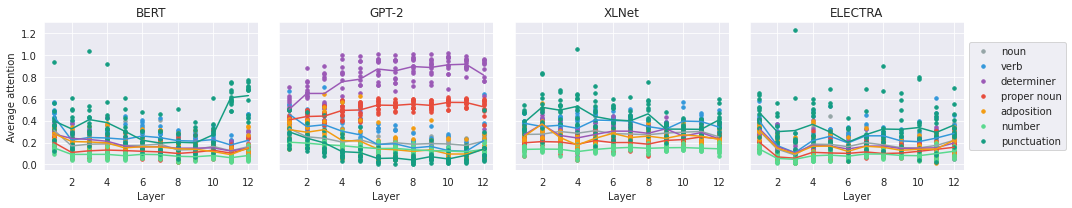

In [10]:
plt.figure(figsize=(15,3))
y_lim = (-0.05,1.3)

# BERT
ax = plt.subplot(1, 4, 1)
ax.set_title("BERT")
for key, color, label in [
     ("noun", "GREY", "noun"), 
     ("verb", "BLUE", "verb"), 
     ("det", "PURPLE", "determiner"), 
     ("propn", "RED", "proper noun"), 
     ("adp", "ORANGE", "adposition"), 
     ("num", "GREEN" ,"number"), 
     ("punct2", "SEA", "punctuation"),
]:
    b_data.add_line(key, ax, color, label, "attention", y_lim=y_lim, pos="leftbottom")
ax.get_legend().remove()

# GPT-2
ax = plt.subplot(1, 4, 2)
ax.set_title("GPT-2")
for key, color, label in [
     ("noun", "GREY", "noun"), 
     ("verb", "BLUE", "verb"), 
     ("det", "PURPLE", "determiner"), 
     ("propn", "RED", "proper noun"), 
     ("adp", "ORANGE", "adposition"), 
     ("num", "GREEN" ,"number"), 
     ("punct2", "SEA", "punctuation"),
]:
    g_data.add_line(key, ax, color, label, "attention", y_lim=y_lim, pos="bottom")
ax.get_legend().remove()

# XLNet
ax = plt.subplot(1, 4, 3)
ax.set_title("XLNet")
for key, color, label in [
     ("noun", "GREY", "noun"), 
     ("verb", "BLUE", "verb"), 
     ("det", "PURPLE", "determiner"), 
     ("propn", "RED", "proper noun"), 
     ("adp", "ORANGE", "adposition"), 
     ("num", "GREEN" ,"number"), 
     ("punct2", "SEA", "punctuation"),
]:
    x_data.add_line(key, ax, color, label, "attention", y_lim=y_lim, pos="bottom")
ax.get_legend().remove()

# ELECTRA
ax = plt.subplot(1, 4, 4)
ax.set_title("ELECTRA")
for key, color, label in [
     ("noun", "GREY", "noun"), 
     ("verb", "BLUE", "verb"), 
     ("det", "PURPLE", "determiner"), 
     ("propn", "RED", "proper noun"), 
     ("adp", "ORANGE", "adposition"), 
     ("num", "GREEN" ,"number"), 
     ("punct2", "SEA", "punctuation"),
]:
    e_data.add_line(key, ax, color, label, "attention", y_lim=y_lim, pos="bottom")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

### Entropy

#### Special tokens

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


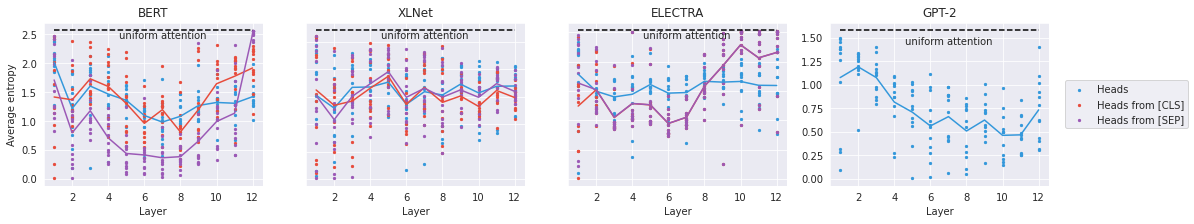

In [11]:
plt.figure(figsize=(18, 3))

# BERT
ax = plt.subplot(1, 4, 1)
ax.set_title("BERT")
b_data.plot_entropies(ax, "entropies", "Heads", c="BLUE", plot_unif=True, pos="leftbottom")
b_data.plot_entropies(ax, "cls", "Heads from [CLS]", c="RED", pos="leftbottom")
b_data.plot_entropies(ax, "sep", "Heads from [SEP]", c="PURPLE", pos="leftbottom")
ax.get_legend().remove()

# XLNet
ax = plt.subplot(1, 4, 2)
ax.set_title("XLNet")
x_data.plot_entropies(ax, "entropies", "Heads", c="BLUE", plot_unif=True, pos="bottom")
x_data.plot_entropies(ax, "cls", "Heads from [CLS]", c="RED", pos="bottom")
x_data.plot_entropies(ax, "sep", "Heads from [SEP]", c="PURPLE", pos="bottom")
ax.get_legend().remove()

# ELECTRA
ax = plt.subplot(1, 4, 3)
ax.set_title("ELECTRA")
e_data.plot_entropies(ax, "entropies", "Heads", c="BLUE", plot_unif=True, pos="bottom")
e_data.plot_entropies(ax, "cls", "Heads from [CLS]", c="RED", pos="bottom")
e_data.plot_entropies(ax, "sep", "Heads from [SEP]", c="PURPLE", pos="bottom")
plt.legend(loc='center left', bbox_to_anchor=(2.25, 0.5))

# GPT-2
ax = plt.subplot(1, 4, 4)
ax.set_title("GPT-2")
g_data.plot_entropies(ax, "entropies", "Heads", c="BLUE", plot_unif=True, pos="leftbottom")
ax.set_ylabel("")
ax.get_legend().remove()

plt.tight_layout()
plt.show()


#### POS tags

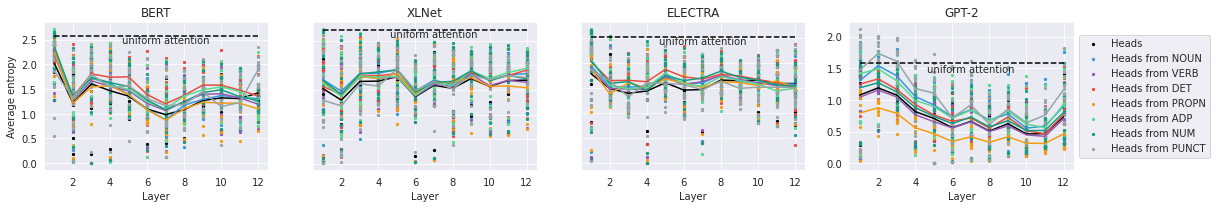

In [12]:

plt.figure(figsize=(17,3))

# BERT
ax = plt.subplot(1,4,1)
ax.set_title("BERT")
b_data.plot_entropies(ax, "entropies", "Heads", c="BLACK", pos="leftbottom", plot_unif=True)
b_data.plot_entropies(ax, "noun", "Heads from NOUN", c="BLUE", pos="leftbottom")
b_data.plot_entropies(ax, "verb", "Heads from VERB", c="PURPLE", pos="leftbottom")
b_data.plot_entropies(ax, "det", "Heads from DET", c="RED", pos="leftbottom")
b_data.plot_entropies(ax, "propn", "Heads from PROPN", c="ORANGE", pos="leftbottom")
b_data.plot_entropies(ax, "adp", "Heads from ADP", c="GREEN", pos="leftbottom")
b_data.plot_entropies(ax, "num", "Heads from NUM", c="SEA", pos="leftbottom")
b_data.plot_entropies(ax, "punct2", "Heads from PUNCT", c="GREY", pos="leftbottom")
ax.get_legend().remove()

# XLNet
ax = plt.subplot(1,4,2)
ax.set_title("XLNet")
x_data.plot_entropies(ax, "entropies", "Heads", c="BLACK", plot_unif=True, pos="bottom")
x_data.plot_entropies(ax, "noun", "Heads from NOUN", c="BLUE", pos="bottom")
x_data.plot_entropies(ax, "verb", "Heads from VERB", c="PURPLE", pos="bottom")
x_data.plot_entropies(ax, "det", "Heads from DET", c="RED", pos="bottom")
x_data.plot_entropies(ax, "propn", "Heads from PROPN", c="ORANGE", pos="bottom")
x_data.plot_entropies(ax, "adp", "Heads from ADP", c="GREEN", pos="bottom")
x_data.plot_entropies(ax, "num", "Heads from NUM", c="SEA", pos="bottom")
x_data.plot_entropies(ax, "punct2", "Heads from PUNCT", c="GREY", pos="bottom")
ax.get_legend().remove()

# ELECTRA
ax = plt.subplot(1,4,3)
ax.set_title("ELECTRA")
e_data.plot_entropies(ax, "entropies", "Heads", c="BLACK", plot_unif=True, pos="bottom")
e_data.plot_entropies(ax, "noun", "Heads from NOUN", c="BLUE", pos="bottom")
e_data.plot_entropies(ax, "verb", "Heads from VERB", c="PURPLE", pos="bottom")
e_data.plot_entropies(ax, "det", "Heads from DET", c="RED", pos="bottom")
e_data.plot_entropies(ax, "propn", "Heads from PROPN", c="ORANGE", pos="bottom")
e_data.plot_entropies(ax, "adp", "Heads from ADP", c="GREEN", pos="bottom")
e_data.plot_entropies(ax, "num", "Heads from NUM", c="SEA", pos="bottom")
e_data.plot_entropies(ax, "punct2", "Heads from PUNCT", c="GREY", pos="bottom")
ax.get_legend().remove()

# GPT-2
ax = plt.subplot(1,4,4)
ax.set_title("GPT-2")
g_data.plot_entropies(ax, "entropies", "Heads", c="BLACK", plot_unif=True, pos="leftbottom")
g_data.plot_entropies(ax, "noun", "Heads from NOUN", c="BLUE", pos="leftbottom")
g_data.plot_entropies(ax, "verb", "Heads from VERB", c="PURPLE", pos="leftbottom")
g_data.plot_entropies(ax, "det", "Heads from DET", c="RED", pos="leftbottom")
g_data.plot_entropies(ax, "propn", "Heads from PROPN", c="ORANGE", pos="leftbottom")
g_data.plot_entropies(ax, "adp", "Heads from ADP", c="GREEN", pos="leftbottom")
g_data.plot_entropies(ax, "num", "Heads from NUM", c="SEA", pos="leftbottom")
g_data.plot_entropies(ax, "punct2", "Heads from PUNCT", c="GREY", pos="leftbottom")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel("")

plt.tight_layout()
plt.show()

## ||f(x)|| (i.e., norm of the value vector times W_O matrix)

## Attention weights * ||f(x)||

### Attention

#### Special tokens

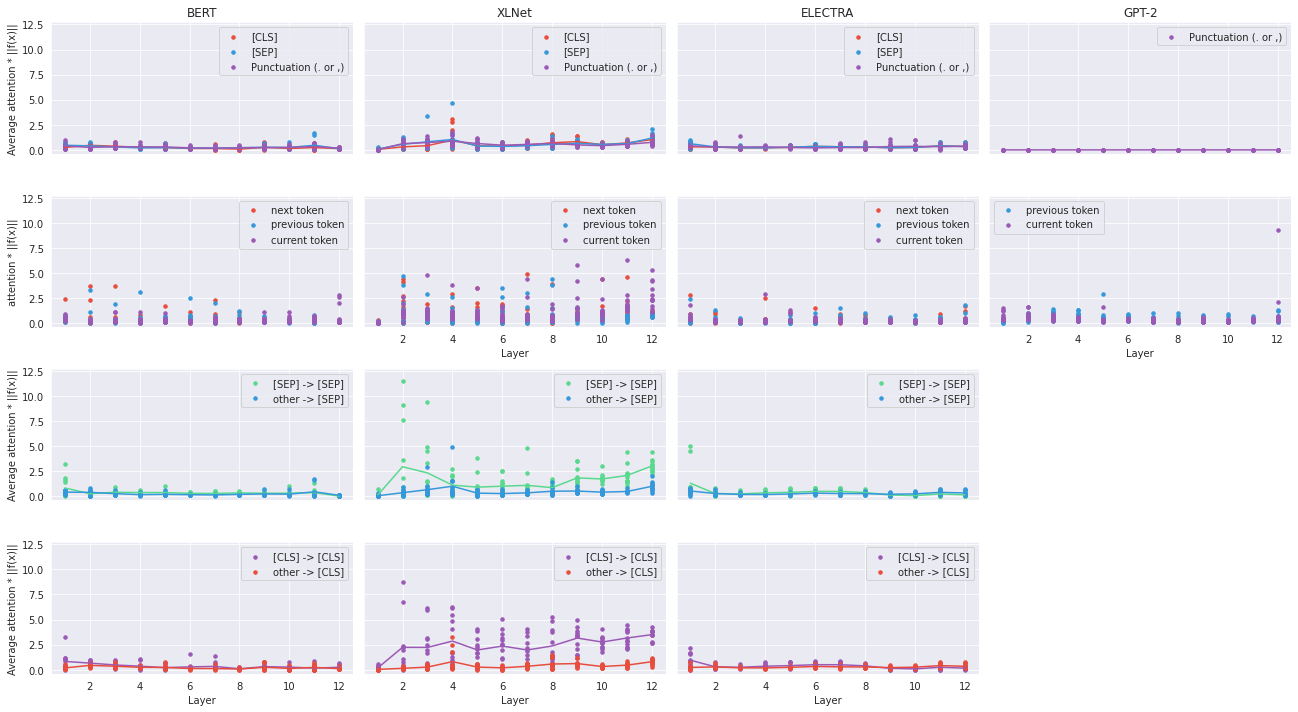

In [13]:
plt.figure(figsize=(18, 10))
y_lim = (-.4, 12.7)

# BERT
ax = plt.subplot(4, 4, 1)
ax.set_title("BERT")
for key, color, label in [
    ("cls", "RED", "[CLS]"),
    ("sep", "BLUE", "[SEP]"),
    ("punct", "PURPLE", "Punctuation (. or ,)"),
]:
    b_data.add_line(key, ax, color, label, "attention * ||f(x)||", y_lim=y_lim, pos="left")

ax = plt.subplot(4, 4, 5)
for key, color, label in [
    ("right", "RED", "next token"),
    ("left", "BLUE", "previous token"), 
    ("self", "PURPLE", "current token"),
]:
    b_data.add_line(key, ax, color, label, "attention * ||f(x)||", plot_avgs=False, y_lim=y_lim, pos="left")

ax = plt.subplot(4, 4, 9)
for key, color, label in [
    ("sep_sep", "GREEN", "[SEP] -> [SEP]"),
    ("rest_sep", "BLUE", "other -> [SEP]"),
    #("sep_rest", "SEA", "[SEP] -> other"),
    #("rest_rest_cls", "PURPLE", "other -> other")
]:
    b_data.add_line(key, ax, color, label, "attention * ||f(x)||", y_lim=y_lim, pos="left")

ax = plt.subplot(4, 4, 13)
for key, color, label in [
    ("cls_cls", "PURPLE", "[CLS] -> [CLS]"),
    ("rest_cls", "RED", "other -> [CLS]"),
    #("cls_rest", "ORANGE", "[CLS] -> other"),
    #("rest_rest_sep", "GREY", "other -> other")
]:
    b_data.add_line(key, ax, color, label, "attention * ||f(x)||", y_lim=y_lim, pos="leftbottom")

# GPT-2
ax = plt.subplot(4, 4, 4)
ax.set_title("GPT-2")
for key, color, label in [
    ("punct", "PURPLE", "Punctuation (. or ,)"),
]:
    g_data.add_line(key, ax, color, label, "attention * ||f(x)||", y_lim=y_lim)

ax = plt.subplot(4, 4, 8)
for key, color, label in [
    ("left", "BLUE", "previous token"), 
    ("self", "PURPLE", "current token"),
]:
    g_data.add_line(key, ax, color, label, "attention * ||f(x)||", plot_avgs=False, y_lim=y_lim, pos="bottom")

# XLNet
ax = plt.subplot(4, 4, 2)
ax.set_title("XLNet")
for key, color, label in [
    ("cls", "RED", "[CLS]"),
    ("sep", "BLUE", "[SEP]"),
    ("punct", "PURPLE", "Punctuation (. or ,)"),
]:
    x_data.add_line(key, ax, color, label, "attention * ||f(x)||", y_lim=y_lim)

ax = plt.subplot(4, 4, 6)
for key, color, label in [
    ("right", "RED", "next token"),
    ("left", "BLUE", "previous token"), 
    ("self", "PURPLE", "current token"),
]:
    x_data.add_line(key, ax, color, label, "attention * ||f(x)||", plot_avgs=False, y_lim=y_lim, pos="bottom")

ax = plt.subplot(4, 4, 10)
for key, color, label in [
    ("sep_sep", "GREEN", "[SEP] -> [SEP]"),
    ("rest_sep", "BLUE", "other -> [SEP]"),
    #("sep_rest", "SEA", "[SEP] -> other"),
    #("rest_rest_sep", "PURPLE", "other -> other")
]:
    x_data.add_line(key, ax, color, label, "attention * ||f(x)||", y_lim=y_lim)

ax = plt.subplot(4, 4, 14)
for key, color, label in [
    ("cls_cls", "PURPLE", "[CLS] -> [CLS]"),
    ("rest_cls", "RED", "other -> [CLS]"),
    #("cls_rest", "ORANGE", "[CLS] -> other"),
    #("rest_rest_cls", "GREY", "other -> other")
]:
    x_data.add_line(key, ax, color, label, "attention * ||f(x)||", y_lim=y_lim, pos="bottom")

# ELECTRA
ax = plt.subplot(4, 4, 3)
ax.set_title("ELECTRA")
for key, color, label in [
    ("cls", "RED", "[CLS]"),
    ("sep", "BLUE", "[SEP]"),
    ("punct", "PURPLE", "Punctuation (. or ,)"),
]:
    e_data.add_line(key, ax, color, label, "attention * ||f(x)||", y_lim=y_lim)

ax = plt.subplot(4, 4, 7)
for key, color, label in [
    ("right", "RED", "next token"),
    ("left", "BLUE", "previous token"), 
    ("self", "PURPLE", "current token"),
]:
    e_data.add_line(key, ax, color, label, "attention * ||f(x)||", plot_avgs=False, y_lim=y_lim)

ax = plt.subplot(4, 4, 11)
for key, color, label in [
    ("sep_sep", "GREEN", "[SEP] -> [SEP]"),
    ("rest_sep", "BLUE", "other -> [SEP]"),
    #("sep_rest", "SEA", "[SEP] -> other"),
    #("rest_rest_sep", "PURPLE", "other -> other")
]:
    e_data.add_line(key, ax, color, label, "attention * ||f(x)||", y_lim=y_lim)

ax = plt.subplot(4, 4, 15)
for key, color, label in [
    ("cls_cls", "PURPLE", "[CLS] -> [CLS]"),
    ("rest_cls", "RED", "other -> [CLS]"),
    #("cls_rest", "ORANGE", "[CLS] -> other"),
    #("rest_rest_cls", "GREY", "other -> other")
]:
    e_data.add_line(key, ax, color, label, "attention * ||f(x)||", y_lim=y_lim, pos="bottom")

plt.tight_layout()
plt.show()

#### POS tags

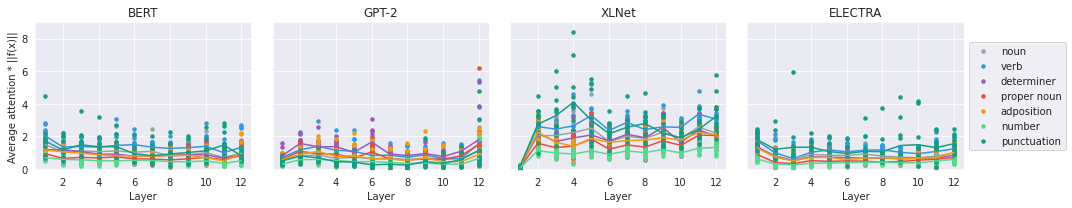

In [14]:
plt.figure(figsize=(15,3))
y_lim = (-0.05,9)


# BERT
ax = plt.subplot(1, 4, 1)
ax.set_title("BERT")
for key, color, label in [
     ("noun", "GREY", "noun"), 
     ("verb", "BLUE", "verb"), 
     ("det", "PURPLE", "determiner"), 
     ("propn", "RED", "proper noun"), 
     ("adp", "ORANGE", "adposition"), 
     ("num", "GREEN" ,"number"), 
     ("punct2", "SEA", "punctuation"),
]:
    b_data.add_line(key, ax, color, label, "attention * ||f(x)||", y_lim=y_lim, pos="leftbottom")
ax.get_legend().remove()

# GPT-2
ax = plt.subplot(1, 4, 2)
ax.set_title("GPT-2")
for key, color, label in [
     ("noun", "GREY", "noun"), 
     ("verb", "BLUE", "verb"), 
     ("det", "PURPLE", "determiner"), 
     ("propn", "RED", "proper noun"), 
     ("adp", "ORANGE", "adposition"), 
     ("num", "GREEN" ,"number"), 
     ("punct2", "SEA", "punctuation"),
]:
    g_data.add_line(key, ax, color, label, "attention * ||f(x)||", y_lim=y_lim, pos="bottom")
ax.get_legend().remove()

# XLNet
ax = plt.subplot(1, 4, 3)
ax.set_title("XLNet")
for key, color, label in [
     ("noun", "GREY", "noun"), 
     ("verb", "BLUE", "verb"), 
     ("det", "PURPLE", "determiner"), 
     ("propn", "RED", "proper noun"), 
     ("adp", "ORANGE", "adposition"), 
     ("num", "GREEN" ,"number"), 
     ("punct2", "SEA", "punctuation"),
]:
    x_data.add_line(key, ax, color, label, "attention * ||f(x)||", y_lim=y_lim, pos="bottom")
ax.get_legend().remove()

# ELECTRA
ax = plt.subplot(1, 4, 4)
ax.set_title("ELECTRA")
for key, color, label in [
     ("noun", "GREY", "noun"), 
     ("verb", "BLUE", "verb"), 
     ("det", "PURPLE", "determiner"), 
     ("propn", "RED", "proper noun"), 
     ("adp", "ORANGE", "adposition"), 
     ("num", "GREEN" ,"number"), 
     ("punct2", "SEA", "punctuation"),
]:
    e_data.add_line(key, ax, color, label, "attention * ||f(x)||", y_lim=y_lim, pos="bottom")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()